# BENVGSC5 - UCL CASA: Urban Simulation

# Constrained Spatial Interaction Models

This notebook largely reproduces Adam Dennett's Rpubs guide to constrained spatial interaction models in Python. See his original R version [here](https://rpubs.com/adam_dennett/259068) and the equivalent Python code [here](https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Unconstrained%20Spatial%20Interaction%20Models.ipynb)

NB Although the content is very similar, there are a couple of changes made for convenience - such as removing the intercept from the Poisson GLMs. As with the previous Python notebook, slight differences in the distance measurements between Python and R mean that results are almost, but not exactly the same as in Dr. Dennett's R code.

## Recap

In the previous practical we learned all about the unconstrained spatial interaction model; how we can use it to estimate flows in a system using values for origin emissiveness or destination attractiveness; how we can tweak the estimates the model produces through adjusting either the parameters associated with the predictor variables, or though using different predictor variables or updating their values; and how we can improve the fits of the model further by calibrating the parameters through using a Poisson regression model.

We saw that even after calibration, our model still only explained around 60% of the variation in the flows that we observed in our system, so can we do any better? Well yes, yes we can!

## Constrained Models

If we return to [Alan Wilson’s 1971 paper](http://journals.sagepub.com/doi/abs/10.1068/a030001), he introduces a full family of spatial interaction models of which the unconstrained model is just the start. And indeed since then, there have been all number of incremental advances and alternatives (such as [Stewart Fotheringham’s Competing Destinations models](https://asu.pure.elsevier.com/en/publications/a-new-set-of-spatial-interaction-models-the-theory-of-competing-d), [Pooler’s production/attraction/cost relaxed models](http://journals.sagepub.com/doi/abs/10.1177/030913259401800102), [Stillwell’s origin/destination parameter specific models](http://journals.sagepub.com/doi/pdf/10.1068/a101187) and [Dennett and Wilson’s own multi-level model](http://journals.sagepub.com/doi/pdf/10.1068/a45398) (to name just a few).

In this session we will explore the rest of Wilson’s family - the Production (origin) Constrained Model; the Attraction (destination) constrained model; and the Doubly Constrained Model.

We will see how we can, again, use a Poisson regression model in R to calibrate these models and how, once calibrated, we can use the models in different contexts, such as Land Use Transportation Interaction (LUTI) modelling, retail modelling and migration modelling.

## Getting started

We need fewer Python libraries than the previous practical as we are using a copy of the dataset that we saved in the last practical and hence have completed all the heavy lifting! Pandas is what we use to store our dataset, matplotlib is for simple plots, numpy is used for some numerical operations, and statsmodels gives us our Poisson GLMS.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

% matplotlib inline

In [42]:
# Load the cdata dataset that we saved in practical 1
cdata = pd.read_csv('cdata.csv',index_col = 0)

# Now create a subset of flows
flows = ["00AA", "00AB", "00AC", "00AD", "00AE", "00AF", "00AG"]

# from cdata, we want the 42 flows that start and end as one of these 7 flows, but not the 7 self flows
# The subset selection has 3 parts: 1) OrigCode in flows; 2) DestCode in flows; 3) Origcode not equal to DestCode.
cdatasub = cdata[cdata['OrigCode'].isin(flows) & cdata['DestCode'].isin(flows) & (cdata['OrigCode'] != cdata['DestCode'])]

In [43]:
# Make a pivot table to look at the flow matrix
cdatasubmat = pd.pivot_table(cdatasub,values='Total',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,194.0,96.0,178.0,66.0,1500.0,3641.0,5675.0
Barnet,96.0,0.0,34.0,5467.0,76.0,12080.0,7709.0,25462.0
Bexley,362.0,132.0,0.0,144.0,4998.0,2470.0,6580.0,14686.0
Brent,40.0,6124.0,28.0,0.0,66.0,8105.0,4145.0,18508.0
Bromley,134.0,162.0,3199.0,201.0,0.0,3780.0,9855.0,17331.0
Camden,36.0,1496.0,32.0,1350.0,60.0,0.0,8795.0,11769.0
City of London,6.0,14.0,0.0,16.0,0.0,335.0,0.0,371.0
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802.0


# 1. Production and Attraction Constrained Models

Wilson’s real contribution to the field was in noticing that the unconstrained gravity model was sub-optimal as it did not make use of all of the available data in the system we are studying.

If we recall, the estimates from our unconstrained model, none of the estimates summed to the observed in and out-flow totals. Our estiamtes only summed to the grand total of flows, but this is because we were really fitting a ‘total constrained’ model which used $k$ - the constant of proportionality - to ensure everything more or less added up (subject to rounding errors).

Where we have a full flow matrix to calibrate parameters, we can incorporate the row (origin) totals, column (destination) totals or both origin and destination totals to _constrain_ our flow estimates to these known values.

There are various reasons for wanting to do this, for example:

1. If we are interested in flows of money into businesses or customers into shops, we might have information on the amount of disposable income and shopping habits of the people living in different areas from loyalty card data. This is known information about our origins and so we could constrain our spatial interaction model to this known information - we can make the assumption that this level of disposable income remains the same. We can then use other information about the attractiveness of places these people might like to shop in (store size, variety / specialism of goods etc.), to estimate how much money a new store opening in the area might make, or if a new out-of-town shopping centre opens, how much it might affect the business of shops in the town centre. This is what is known in the literature as the ‘retail model’ and is perhaps the most common example of a __Production (origin) Constrained Spatial Interaction Model.__

2. We might be interested in understanding the impact of a large new employer in an area on the local flows of traffic or on the demand for new worker accommodation nearby. A good example of where this might be the case is with large new infrastructure developments like new airports. For example, before the go-ahead for the new third runway at Heathrow was given, one option being considered was a new runway in the Thames Estuary. If a new airport was built here, what would be the potential impact on transport flows in the area and where might workers commute from? This sort of scenario could be tested with an __Attraction (destination) Constrained Spatial Interaction Model__ where the number of new jobs in a destination is known (as well as jobs in the surrounding area) and the model could be used to estimate where the workers will be drawn from (and their likely travel-to-work patterns). This model is exactly the sort of model Land Use Transport Interaction (LUTI) model that was constructed by the Mechanicity Team in CASA - details [here](http://www.mechanicity.info/research/land-use-transport-interaction-modelling/) if you are interested…

3. We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
 1. the ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
 2. how the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?
 
# 2. Production Constrained Model

1 $$T_{ij} = A_{i}O_{i}W_{j}^{\alpha}d_{ij}^{-\beta}$$
where

2 $$O_{i} = \sum_{j}T_{ij}$$
and

3 $$A_{i} = \frac{1}{\sum_{j}W_{j}^{\alpha}d_{ij}^{-\beta}}$$

In the production-constrained model, $O_{i}$ does not have a parameter as it is a known constraint, although it could be dissaggregated and receive a superscript index. $A_{i}$ is known as a _balancing factor_ and is a vector of values which relate to each origin, $i$, which do a similar job to $k$ in the unconstrained/total constrained model. Specifically, $A_{i}$ ensures that flow estimates from each origin sum to the known totals, $O_{i}$ rather than just the overall total. This constraint is given by equation 2 above.

Now at this point, we could calculate all of the $O_{i}$s and $A_{i}$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python, Statsmodels and the Poisson GLM to do this work for us!

We set about re-specifying the Production-Constrained model as a Poisson regression model in a similar way to how we did before. We need to take logs of the right-hand side of equation and assume that these are logarithmially linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. Equation 1 (above) then becomes:

4 $$\lambda_{ij} = \exp( \mu_{i} + \alpha \ln W_{j} - \beta \ln d_{ij} )$$

In equation 4, $\mu_{i}$ is the equivalent of the vector $A_{i}O_{i}$. In the Poisson regression approach we are taking to estimation it is simply a categorical variable that identifies each discrete origin zone (e.g. by name or by zone code). For instance in the case of Barking and Dagenham we wouldn't pass the count of origin flows (5675), we would simply pass the variable that identifies that zone, perhaps 'Barking and Dagenham' (using 'Orig'), '00AB' (using 'OrigCode'), or 'E09000002' (using 'OrigNewCode').

Finally, in Python (and R, actually) we specify the regression with the tag '-1' at the end of the equation. This is because we don't have a constant (like $k$) in the constrained spatial interaction model, and as such we don't want to estimate an intercept. If we didn't remove the intercept the model would set the $\mu$ value for an arbitrary zone to be the intercept, and then the $\mu$ values for all other zones would be relative to that first zone. By 'removing' the intercept with the '-1' we are actually setting the intercept to be 0, and hence each estiamted $mu_{i}$ value is relative to 0, making things easier for us.

In [45]:
# Run a production constrained SIM using a Poisson GLM.
# We'll do this using statsmodels, and the formula approach.
# Here we're just using the 7 borough sub sample of data.
# First take logs of the relevant fields
cdatasub = cdatasub.assign(log_wj2_destsal = lambda x: np.log(x['wj2_destsal']))
cdatasub = cdatasub.assign(log_dist = lambda x: np.log(x['dist']))

# Here we specify a model with no intercept (given by the -1 in the formula)
# In practice this means that all AiOis are estimated against an intercept of zero.
# Including the interval would mean setting the first borough in OrigNewCode to the intercept
# and interpreting all other categories in relation to that, which is less useful but would still work.
formula = "Total ~ OrigNewCode + log_wj2_destsal + log_dist -1"
prodSim = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
prodSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -14551.
Date:                Mon, 05 Feb 2018   Deviance:                       28788.
Time:                        12:31:14   Pearson chi2:                 2.84e+04
No. Iterations:                     8                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigNewCode[E09000001]     4.7076      0.119     39.458      0.000       4.474       4.941
OrigNewCode[E09000002]     7.9961      0.114     70.267      0.000       7.773       8.219
OrigNewCode[E09000003]     8.9812      0.111     81.058      0.000       8.764       9.198
OrigNewCode[E09000004]     8.9571      0.113     79.443      0.000       8.736       9.178
OrigNewCode[E09000005]     8.4777      0.111     76.709      0.000       8.261       8.694
OrigNewCode[E09000006]     9.4865      0.114     83.016      0.000       9.262       9.710
OrigNewCode[E09000007]     6.9794      0.110     63.635      0.000       6.764       7.194
log_wj2_destsal            2.0471      0.010    201.778      0.000       2.027       2.067
log_dist                  -2.2423      0.011   -197.074      0.000      -2.265      -2.220
==========================================================================================
"""

So, what do we have from this model?

The $\alpha$ parameter related to destination attractiveness is 2.0471

The $\beta$ distance decay parameter is -2.2423

The 'coef' for each origin (given here as OrigNewCode[_code_]) is the logged $A_{i}O_{i}$ value for that origin.

# 2.1 Model Estimates

Now at this point you will be wanting to know what affect the constraints have had on the estimates produced by the model, so let’s plug the parameters back into Equation 4 and take a look.

First we need some $O_{i}$ and $D_{j}$ columns to store the total in and out flows. We can do this by grouping the dataframe by the Origin and Destination codes, and summing up the 'Total' flows.

In [47]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
# First get the origin sums and rename the column created
O_i = cdatasub.groupby('OrigNewCode')['Total'].sum().to_frame()
O_i.rename(columns = {'Total':'O_i'}, inplace=True)
# Now get the destination sums
D_j = cdatasub.groupby('DestNewCode')['Total'].sum().to_frame()
D_j.rename(columns = {'Total':'D_j'}, inplace=True)

# Merge in O_i
cdatasub = cdatasub.merge(O_i,left_on='OrigNewCode',right_index=True)

# Merge in D_j
cdatasub = cdatasub.merge(D_j,left_on='DestNewCode',right_index=True)

Now we need to get our $\mu$ values out, this is slightly tricky because in order to merge the values back into the dataframe we need the zonecode (e.g. E09000001) and not the model output (e.g. OrigNewCode[E09000001]).

Dr. Dennett uses a regular expression (regex) approach, which I have mimiced below, however it's probably overkill to be honest, and it might not always work depending on the specific patterns present, so there's also a much simpler string indexing approach below too. The string index approach works by removing a given number of the first and last characters in the string and should be straightforward to reproduce with differently named variables.

In [48]:
# Do the same with the prodSim parameter estimates, first create a dataframe of 
mu_i = prodSim.params.to_frame()

# Rename index values associated with geographies so I can merge the values with cdatasub

# This approach uses a regex pattern that replaces all values with '' unless they are in the set E0123456789
mu_i.rename(index = dict(zip(mu_i.index[0:-2].values, mu_i.index[0:-2].str.replace(r'[^E0123456789]','').values)),inplace=True)
# An easier approach is to simply subset the strings using a list comprehension.
#mu_i.rename(index = dict(zip(mu_i.index[:-2].values,[x[12:-1] for x in mu_i.index[:-2].values])))

# Set column name to mu_I
mu_i.rename(columns = {0:'mu_i'}, inplace=True)

# Now merge
cdatasub = cdatasub.merge(mu_i, left_on='OrigNewCode',right_index=True)
cdatasub.head()

,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,Train,Bus,Taxi,...,wj1_destpop,wj2_destsal,dist,TotalNoIntra,offset,log_wj2_destsal,log_dist,O_i,D_j,mu_i
1,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,1788,55,0,...,12000,38300,16021.038518,3641,1.0,10.553205,9.681658,5675,40725,7.996147
67,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,28,8,0,...,159000,18700,25075.424943,194,1.0,9.836279,10.129644,5675,8122,7.996147
100,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,6,4,0,...,112000,18300,9629.985305,96,1.0,9.814656,9.172637,5675,3389,7.996147
133,Barking and Dagenham,00AB,Brent,00AE,178,0,47,29,3,0,...,127000,16500,27872.037104,178,1.0,9.711116,10.235379,5675,7356,7.996147
166,Barking and Dagenham,00AB,Bromley,00AF,66,0,7,10,0,0,...,164000,19100,20102.098077,66,1.0,9.857444,9.908579,5675,5266,7.996147


Finally, we can grab the alpha and beta parameters from the prodSim object (the Poisson regression model we ran) and plug everything into the Equation to create a new estimate of flows called 'prodsimest'.

In [49]:
# Save parameter estimates into variables
alpha = prodSim.params[7]
beta = prodSim.params[8]

# Now generate some rounded estimates by 
cdatasub['prodsimest'] = np.round(np.exp(cdatasub['mu_i'] + alpha * cdatasub['log_wj2_destsal'] + beta * cdatasub['log_dist']))

# 2.2 Accessing the model output

So what do the outputs from our Production Constrained Model look like? How has the goodness-of-fit improved and how can we start to use this a bit like a retail model and assess the likely impacts of changing destination attractiveness etc.?

## 2.2.1 The flow matrix

In [50]:
# Now look at the matrix of flows
pd.pivot_table(cdatasub,values='prodsimest',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,225.0,1843.0,138.0,386.0,412.0,2670.0,5674.0
Barnet,450.0,0.0,388.0,6905.0,348.0,7550.0,9821.0,25462.0
Bexley,3755.0,396.0,0.0,295.0,3557.0,816.0,5868.0,14687.0
Brent,215.0,5392.0,226.0,0.0,248.0,5663.0,6765.0,18509.0
Bromley,1224.0,553.0,5533.0,503.0,0.0,1214.0,8304.0,17331.0
Camden,99.0,907.0,96.0,871.0,92.0,0.0,9703.0,11768.0
City of London,17.0,32.0,18.0,28.0,17.0,259.0,0.0,371.0
All,5760.0,7505.0,8104.0,8740.0,4648.0,15914.0,43131.0,93802.0


And compared to the original observed flows?

In [14]:
# Compared to the original flows - sum across columns to see constraints working.
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,194.0,96.0,178.0,66.0,1500.0,3641.0,5675.0
Barnet,96.0,0.0,34.0,5467.0,76.0,12080.0,7709.0,25462.0
Bexley,362.0,132.0,0.0,144.0,4998.0,2470.0,6580.0,14686.0
Brent,40.0,6124.0,28.0,0.0,66.0,8105.0,4145.0,18508.0
Bromley,134.0,162.0,3199.0,201.0,0.0,3780.0,9855.0,17331.0
Camden,36.0,1496.0,32.0,1350.0,60.0,0.0,8795.0,11769.0
City of London,6.0,14.0,0.0,16.0,0.0,335.0,0.0,371.0
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802.0


Here it is very easy to see the origin constraints working. The sum across all destinations (columns) for each origin (rows) is the same (subject to rounding - note Barking and Dagenham, Bexley, Brent and Camden are all off by 1) in the predicted trips matrix and the observed trips matrix. Essentially, $\sum_{j}T_{ij} = \sum_{j}\lambda_{ij} = O_{i}$ more or less holds, but the same is not true for destinations summing for all origins, for instance, Barking and Dagenham is predicted many more trips than in reality, and Camden is predicted far fewer. In this sense, $\sum_{i}T_{ij} = \sum_{i}\lambda_{ij} = D_{j}$

## 2.2.2 How does the attraction constrained model perform?

NB I've copied over the same function that we used in the last practical.

In [55]:
# Goodness of fit (functions borrowed from previous practical)

# Function to compute R^2
def calcR2(obs,est):
    return np.power(np.corrcoef(obs,est),2.0)[0][1]

# Function to compute RMSE
def calcRMSE(obs,est):
    return np.sqrt((np.power((obs - est),2.0)).mean())

print "R squared =", calcR2(cdatasub['Total'],cdatasub['prodsimest'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['prodsimest'])

R squared = 0.817447925947
RMSE = 1383.01497771


Clearly by constraining our model estimates to known origin totals, the fit of the model has improved quite considerably - from around 0.67 in the unconstrained model to around 0.82 in this model. The RMSE has also dropped quite noticably.

## 2.2.3 A 'what if...' scenario

Now that we have calibrated our parameters and produced some estimates, we can start to play around with some what-if scenarios.

In a 'what if' scenario, we make the assumption that the parameters for alpha and beta are universal (that is - they don't change subject to circumstance), and we use this model as a basis for exploring different scenarios by changing other data in the model, such as the observed $W_{j}$ values, here median income at the destination (the attractive force), or the cost of travelling between two places. As we're using straight-line distance to equal cost here it doesn't make a great deal of sense to change that in our model though!

So, by way of example - What if the government invested loads of money into a new Car Plant in Barking and Dagenham and as a result, average wages increased from a mere £16,200 to £25,000. A far fetched scenario, but one that could make a good experiment.

First create create a new variable with these altered salaries:

In [57]:
# now let's try a what if scenario
# The scenario says if destination median income is 16200, set the new value to be 25000, otherwise leave it the same.
cdatasub = cdatasub.assign(wj3_destsalScenario = np.where(cdatasub['wj2_destsal'] == 16200, 25000,cdatasub['wj2_destsal']))
# Take the log of the new variable
cdatasub = cdatasub.assign(log_wj3_destsalScenario = lambda x: np.log(x['wj3_destsalScenario']))

Now let’s plug these new values into the model and see how this changes the flows in the system…

In [59]:
# Now plug these new values into the model and see what happens
cdatasub['prodsimest_scenario'] = np.round(np.exp(cdatasub['mu_i'] + alpha * cdatasub['log_wj3_destsalScenario'] + beta * cdatasub['log_dist']))
# Here's the matrix
pd.pivot_table(cdatasub,values='prodsimest_scenario',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,225.0,1843.0,138.0,386.0,412.0,2670.0,5674.0
Barnet,1093.0,0.0,388.0,6905.0,348.0,7550.0,9821.0,26105.0
Bexley,9126.0,396.0,0.0,295.0,3557.0,816.0,5868.0,20058.0
Brent,521.0,5392.0,226.0,0.0,248.0,5663.0,6765.0,18815.0
Bromley,2975.0,553.0,5533.0,503.0,0.0,1214.0,8304.0,19082.0
Camden,240.0,907.0,96.0,871.0,92.0,0.0,9703.0,11909.0
City of London,42.0,32.0,18.0,28.0,17.0,259.0,0.0,396.0
All,13997.0,7505.0,8104.0,8740.0,4648.0,15914.0,43131.0,102039.0


You will notice that by increasing the average salary in Barking and Dagenham, we’ve increased flows into Barking and Dagenham, but have not reduced the flows into other zones - the original constraints are still working on the other zones. As a result our new count of total flows (102,039) is larger than the observed (93,802). 

One way to resolve this issue and reconstrain the total, now that we have calibrated our parameters, is to return to the multiplicative model in Equation 1 and run this model after calculating our own $A_{i}$ balancing factors.

Let's first look at how to calculate the $A_{i}$ values for the original (non-scenario) model, using the $\alpha$ and $\beta$ values that we derived with the Poisson regression model.

In [60]:
# As the total flows are now wrong, we need to recalculate the balancing factors.
# Let's do it first for the original estimates and see if we get the same results.

# Calculate some wj^alpha and dij^beta values
wj2_alpha = np.power(cdatasub['wj2_destsal'],alpha)
dist_beta = np.power(cdatasub['dist'],beta)

# Calculate the first stage of the Ai values
cdatasub = cdatasub.assign(Ai1 = wj2_alpha*dist_beta)

# Now sum over all js
A_i = cdatasub.groupby('OrigNewCode')['Ai1'].sum().to_frame()
A_i.rename(columns = {'Ai1':'A_i'}, inplace=True)

# Merge in the inverse of A_i
cdatasub = cdatasub.merge(1.0/A_i,left_on='OrigNewCode',right_index=True)

# Now make the flow estimates
cdatasub['prodsimest_Ais'] = np.round(cdatasub['A_i'] * cdatasub['O_i'] * wj2_alpha * dist_beta)
# Here's the matrix, it works!
pd.pivot_table(cdatasub,values='prodsimest_Ais',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,225.0,1843.0,138.0,386.0,412.0,2670.0,5674.0
Barnet,450.0,0.0,388.0,6905.0,348.0,7550.0,9821.0,25462.0
Bexley,3755.0,396.0,0.0,295.0,3557.0,816.0,5868.0,14687.0
Brent,215.0,5392.0,226.0,0.0,248.0,5663.0,6765.0,18509.0
Bromley,1224.0,553.0,5533.0,503.0,0.0,1214.0,8304.0,17331.0
Camden,99.0,907.0,96.0,871.0,92.0,0.0,9703.0,11768.0
City of London,17.0,32.0,18.0,28.0,17.0,259.0,0.0,371.0
All,5760.0,7505.0,8104.0,8740.0,4648.0,15914.0,43131.0,93802.0


So that is it for calculating your $A_{i}$ values. The flow matrix above is the same as the original model estimates!

In fact, we can demonstrate that the output $\mu_{i}$ we get from the Poisson regression is simply $\log(A_{i}O_{i})$ or vice versa by comparing the two quantities.

In [19]:
# Note that the multiplication of A_i and O_i above is simply the exponential of mu_i from the poisson model!
# I've truncated to 8 decimal places because a slight difference creeps from 9 d.p. due to computation.
# NB This equality prints true if all values are the same i.e. A_i*O_i == exp(mu_i) for all i
(np.round(cdatasub['A_i'] * cdatasub['O_i'],8) == np.round(np.exp(cdatasub['mu_i']),8)).all()

True

Now the same approach can be applied to rebalancing our scenario data, under the assumption that $\alpha$ and $\beta$ are universal. Remember, though, that you will need to recalculate $A_{i}$ each time you want to create a new set of estimates based on a new scenario.

In [61]:
# Now let's rebalance the estimates for our scenario.

# Calculate some new wj^alpha values
wj3_alpha = np.power(cdatasub['wj3_destsalScenario'],alpha)

# Calculate the first stage of the Ai values
cdatasub = cdatasub.assign(Ai1 = wj3_alpha*dist_beta)

# Now sum over all js
A_i = cdatasub.groupby('OrigNewCode')['Ai1'].sum().to_frame()
A_i.rename(columns = {'Ai1':'A_i'}, inplace=True)

# Drop previous A_i column
cdatasub.drop(['A_i'], axis = 1, inplace = True)
# Merge in the inverse of A_i
cdatasub = cdatasub.merge(1.0/A_i,left_on='OrigNewCode',right_index=True)

# Now make the scenario flow estimates
cdatasub['prodsimest_scenario'] = np.round(cdatasub['A_i'] * cdatasub['O_i'] * wj3_alpha * dist_beta)
# Here's the matrix, it works (subject to a couple of rounding errors)!
pd.pivot_table(cdatasub,values='prodsimest_scenario',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,225.0,1843.0,138.0,386.0,412.0,2670.0,5674.0
Barnet,1066.0,0.0,378.0,6735.0,340.0,7364.0,9579.0,25462.0
Bexley,6682.0,290.0,0.0,216.0,2604.0,597.0,4296.0,14685.0
Brent,513.0,5304.0,222.0,0.0,244.0,5571.0,6654.0,18508.0
Bromley,2702.0,502.0,5025.0,457.0,0.0,1102.0,7542.0,17330.0
Camden,238.0,897.0,95.0,861.0,91.0,0.0,9588.0,11770.0
City of London,39.0,30.0,17.0,26.0,16.0,243.0,0.0,371.0
All,11240.0,7248.0,7580.0,8433.0,3681.0,15289.0,40329.0,93800.0


So, subject to rounding errors, we have rebalanced the scenario to the original origin and total constraints.

There are a number of things to note here. Firstly, we see flows into Barking and Dagenham have virtually doubled, while flows into other Boroughs have reduced.

Secondly, Barking and Dagenham was a poor estimate anyway - the model was very much over-estimating flows into this Borough. Increasing the median income in this borough has significantly increased flows, indicating that there are probably lots of other things that might be discouraging people from working in this borough.

Thirdly, Our origin constraints are now holding again.

# 3. Attraction Constrained Model

The attraction constrained Model is virtually the same as the production constrained model:

5 $$T_{ij} = D_{j}B_{j}V_{i}^{\mu}d_{ij}^{-\beta}$$
where

6 $$D_{j} = \sum_{i}T_{ij}$$
and

7 $$B_{j} = \frac{i}{\sum_{i}V_{i}^{\mu}d_{ij}^{-\beta}}$$
or framed as a Poisson regression:

8 $$\lambda_{ij} = \exp(\mu \ln V_{i} + \alpha_{i} - \beta \ln d_{ij})$$

In which $\alpha_{i}$ represents the $D_{j}B_{j}$ part of the model equation.

In [62]:
# Now for a quick attraction constrained model
cdatasub = cdatasub.assign(log_vi1_origpop = lambda x: np.log(x['vi1_origpop']))

formula = "Total ~ DestNewCode + log_vi1_origpop + log_dist -1"
attrSim = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
attrSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -11902.
Date:                Mon, 05 Feb 2018   Deviance:                       23489.
Time:                        15:02:10   Pearson chi2:                 2.26e+04
No. Iterations:                     7                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DestNewCode[E09000001]     1.9189      0.135     14.251      0.000       1.655       2.183
DestNewCode[E09000002]    -1.6652      0.141    -11.795      0.000      -1.942      -1.388
DestNewCode[E09000003]     0.6945      0.134      5.169      0.000       0.431       0.958
DestNewCode[E09000004]    -0.0065      0.137     -0.047      0.962      -0.275       0.262
DestNewCode[E09000005]     0.3785      0.136      2.791      0.005       0.113       0.644
DestNewCode[E09000006]     0.8223      0.135      6.073      0.000       0.557       1.088
DestNewCode[E09000007]     1.6193      0.135     11.955      0.000       1.354       1.885
log_vi1_origpop            1.5587      0.011    137.030      0.000       1.536       1.581
log_dist                  -1.2037      0.007   -171.500      0.000      -1.217      -1.190
==========================================================================================
"""

We can examine how the constraints hold for destinations this time.

In [22]:
# Get the estimates - note I've done it the easy way here!
cdatasub['attrsimfitted'] = np.round(attrSim.predict())
# Here's the matrix
pd.pivot_table(cdatasub,values='attrsimfitted',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,255.0,401.0,164.0,379.0,836.0,1490.0,3525.0
Barnet,123.0,0.0,521.0,4021.0,1074.0,11940.0,8986.0,26665.0
Bexley,225.0,608.0,0.0,435.0,2193.0,2121.0,3998.0,9580.0
Brent,76.0,3886.0,360.0,0.0,825.0,9445.0,6790.0,21382.0
Bromley,168.0,992.0,1735.0,789.0,0.0,3581.0,6571.0,13836.0
Camden,79.0,2335.0,355.0,1911.0,758.0,0.0,12890.0,18328.0
City of London,4.0,47.0,18.0,37.0,37.0,345.0,0.0,488.0
All,675.0,8123.0,3390.0,7357.0,5266.0,28268.0,40725.0,93804.0


Compared to...

In [23]:
# Compared to the original flows - sum down rows to see constraints working.
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,194.0,96.0,178.0,66.0,1500.0,3641.0,5675.0
Barnet,96.0,0.0,34.0,5467.0,76.0,12080.0,7709.0,25462.0
Bexley,362.0,132.0,0.0,144.0,4998.0,2470.0,6580.0,14686.0
Brent,40.0,6124.0,28.0,0.0,66.0,8105.0,4145.0,18508.0
Bromley,134.0,162.0,3199.0,201.0,0.0,3780.0,9855.0,17331.0
Camden,36.0,1496.0,32.0,1350.0,60.0,0.0,8795.0,11769.0
City of London,6.0,14.0,0.0,16.0,0.0,335.0,0.0,371.0
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802.0


and we can test the goodness-of-fit in exactly the same way as before:

In [24]:
# Finally, the goodness of fit for the attraction constrained model
print "R squared =", calcR2(cdatasub['Total'],cdatasub['attrsimfitted'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['attrsimfitted'])

R squared = 0.844315885864
RMSE = 1310.21563111


OK, that’s where I’ll leave singly constrained models for now. There are, of course, plenty of things you could try out. For example:

1. You could try mapping the coefficients or the residual values from the model to see if there is any patterning in either the over or under prediction of flows.
2. You could try running your own version of a LUTI model by first calibrating the model parameters and plugging these into a multiplicative version of the model, adjusting the destination constraints to see which origins are likely to generate more trips.

# 4. Doubly Constrained Model

Now, the model in the family you have all been waiting for - the big boss, the daddy, the __doubly constrained model!__

Let's begin with the formula:

9 $$T_{ij} = A_{i}O_{i}B_{j}D_{j}d_{ij}^{-\beta}$$
where

10 $$O_{i} = \sum_{j}T_{ij}$$
11 $$D_{j} = \sum_{i}T_{ij}$$
and

12 $$A_{i} = \frac{1}{\sum_{j}B_{j}D_{j}d_{ij}^{-\beta}}$$
13 $$B_{j} = \frac{1}{\sum_{i}A_{i}O_{i}d_{ij}^{-\beta}}$$

Now, the astute will have noticed that the calculation of $A_{i}$ relies on knowing $B_{j}$ and the calculation of $B_{j}$ relies on knowing $A_{i}$. This is a potentially tricky situation, how can you calcualte either if both are unknown?

Well, I wrestled with that for a while until I came across [this paper by Martyn Senior](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) where he sketches out a very useful algorithm for iteratively arriving at values for $A_{i}$ and $B_{j}$ by setting $B_{j}$ equal to 1 initially, and then iteratively refining the value of each until they are stable (that is they converge on a particular value).

We will return to this later, but for now, we will once again use the awesome power of Python to deal with this difficulty for us!

We can run the doubly constrained model in effectively the same way as we ran the singly constrained models:

14 $$\lambda_{ij} = \exp(\mu_{i} + \alpha_{i} - \beta \ln d_{ij} )$$

Or in Python:

In [63]:
# Now the doubly constrained model!
formula = "Total ~ Orig + Dest + log_dist -1"
doubSim = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
doubSim.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -2802.4
Date:                Mon, 05 Feb 2018   Deviance:                       5290.3
Time:                        15:16:06   Pearson chi2:                 4.60e+03
No. Iterations:                     8                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dagenham]    28.1500      0.143    196.500      0.000      27.869      28.431
Orig[Barnet]                  28.5771      0.135    211.481      0.000      28.312      28.842
Orig[Bexley]                  29.1542      0.142    205.003      0.000      28.875      29.433
Orig[Brent]                   27.9590      0.133    209.623      0.000      27.698      28.220
Orig[Bromley]                 29.7550      0.145    205.622      0.000      29.471      30.039
Orig[Camden]                  26.7334      0.128    209.305      0.000      26.483      26.984
Orig[City of London]          23.8944      0.140    171.051      0.000      23.621      24.168
Dest[T.Barnet]                 2.9636      0.041     71.598      0.000       2.883       3.045
Dest[T.Bexley]                 1.4611      0.043     33.876      0.000       1.377       1.546
Dest[T.Brent]                  2.3925      0.041     57.939      0.000       2.312       2.473
Dest[T.Bromley]                2.6533      0.041     64.707      0.000       2.573       2.734
Dest[T.Camden]                 3.5594      0.040     89.094      0.000       3.481       3.638
Dest[T.City of London]         4.1095      0.040    103.336      0.000       4.032       4.187
log_dist                      -2.5032      0.015   -171.845      0.000      -2.532      -2.475
==============================================================================================
"""

Produce the various flows:

In [26]:
# Get the estimates
cdatasub['doubsimfitted'] = np.round(doubSim.predict())
# Here's the matrix
pd.pivot_table(cdatasub,values='doubsimfitted',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,317.0,773.0,137.0,404.0,989.0,3055.0,5675.0
Barnet,25.0,0.0,69.0,5542.0,184.0,12967.0,6675.0,25462.0
Bexley,490.0,554.0,0.0,301.0,4492.0,1978.0,6871.0,14686.0
Brent,10.0,5288.0,36.0,0.0,119.0,8893.0,4162.0,18508.0
Bromley,141.0,813.0,2487.0,550.0,0.0,3114.0,10226.0,17331.0
Camden,7.0,1131.0,22.0,813.0,61.0,0.0,9736.0,11770.0
City of London,1.0,20.0,3.0,13.0,7.0,328.0,0.0,372.0
All,674.0,8123.0,3390.0,7356.0,5267.0,28269.0,40725.0,93804.0


And check the goodness of fit

In [27]:
# Now, the goodness of fit for the doubly constrained model
print "R squared =", calcR2(cdatasub['Total'],cdatasub['doubsimfitted'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['doubsimfitted'])

R squared = 0.982471829461
RMSE = 440.269560286


So the goodness of fit has shot up and we can clearly see the origin and destination constraints working, and for most sets of flows, the model is now producing some good estimates. However, there are still some errors in the flows, particularly for estimates between Barking and Dagenham and Bexley or Barnet and Camden.

Is there anything more we can do? Yes, of course there is.

# 4.1 Tweaking our Model
## 4.1.1 Distance Decay

Now, all of the way through these practicals, we have assumed that the distance decay parameter follows a negative power law. Well, it doesn’t need to.

In [Wilson’s original paper](http://journals.sagepub.com/doi/abs/10.1068/a030001), he generalised the distance decay parameter to:

$$f(d_{ij})$$

Where $f$ represents some function of distance describing the rate at which the flow interactions change as distance changes. Lots of people have written about this, including [Taylor (1971)](http://onlinelibrary.wiley.com/doi/10.1111/j.1538-4632.1971.tb00364.x/full).

For the inverse power law that we have been using is one possible function of distance, the other common one that is used is the negative exponential function:

$$\exp(-\beta d_{ij})$$

We can get a feel for how different distance decay parameters work by plotting some sample data:

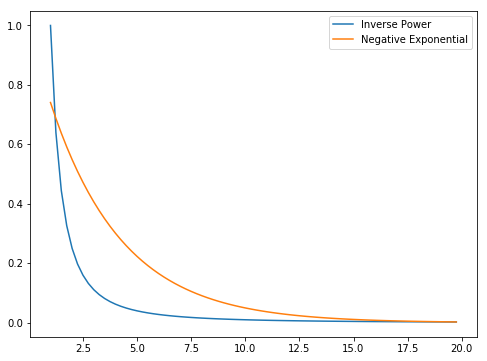

In [28]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph so distance decay parameters to get a feel for how they work.
xs = np.arange(1.0,20.0,0.25)
# inverse square power
y_inv_power = np.power(xs,-2)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,6))
ax.plot(xs,y_inv_power, label = "Inverse Power")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential')
ax.legend();

Here you can see quite clearly that the inverse power function specified has a more rapid distance decay effect than the negative exponential function specified. It is important to note that this won't always be the case, as it depends on the values of $\beta$ actually chosen.

There is no hard and fast rule as to which function to pick, however some studies have suggested that square laws are good for short range interactions, while exponential models tend to be better for long range interactions. In real life, what this means is that if the observed interactions drop off very rapidly with distance, then they might be more likely to follow an inverse power law. This might be the case when looking at trips to the local convenience store by walking, for example. On the other hand, if the effect of distance is less severe (for example migration across the country for a new job) then the negative exponential funtion might be more appropriate.

As [Tayor Oshan points out in his excellent Primer](http://openjournals.wu.ac.at/region/paper_175/175.html) what this means for our Poisson regression model is that we simply substitute $−\beta \ln d_{ij}$ for $−\beta ⁡d_{ij}$:

In [64]:
# Run a production constrained SIM with a negative exponential cost function.
formula = "Total ~ Orig + Dest + dist -1"
doubSimExp = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
doubSimExp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1854.4
Date:                Mon, 05 Feb 2018   Deviance:                       3394.5
Time:                        15:32:30   Pearson chi2:                 3.24e+03
No. Iterations:                     8                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dagenham]     6.8347      0.044    156.514      0.000       6.749       6.920
Orig[Barnet]                   7.2600      0.040    180.410      0.000       7.181       7.339
Orig[Bexley]                   7.8639      0.041    191.386      0.000       7.783       7.944
Orig[Brent]                    6.7164      0.040    166.610      0.000       6.637       6.795
Orig[Bromley]                  8.5412      0.043    198.893      0.000       8.457       8.625
Orig[Camden]                   5.9904      0.040    148.536      0.000       5.911       6.069
Orig[City of London]           2.9570      0.065     45.303      0.000       2.829       3.085
Dest[T.Barnet]                 3.1301      0.042     75.198      0.000       3.049       3.212
Dest[T.Bexley]                 1.3436      0.043     31.101      0.000       1.259       1.428
Dest[T.Brent]                  2.6288      0.042     63.330      0.000       2.547       2.710
Dest[T.Bromley]                2.5919      0.041     63.220      0.000       2.512       2.672
Dest[T.Camden]                 3.7158      0.040     92.597      0.000       3.637       3.794
Dest[T.City of London]         4.0190      0.040    101.123      0.000       3.941       4.097
dist                          -0.0002   1.09e-06   -160.256      0.000      -0.000      -0.000
==============================================================================================
"""

In [65]:
# Get the estimates
cdatasub['doubsimfitted_exp'] = np.round(doubSimExp.predict())
# Here's the matrix
pd.pivot_table(cdatasub,values='doubsimfitted_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,266.0,663.0,99.0,371.0,1125.0,3151.0,5675.0
Barnet,18.0,0.0,29.0,5277.0,63.0,13100.0,6975.0,25462.0
Bexley,484.0,319.0,0.0,177.0,4690.0,1975.0,7041.0,14686.0
Brent,6.0,5059.0,16.0,0.0,55.0,8725.0,4647.0,18508.0
Bromley,153.0,390.0,2650.0,352.0,0.0,3054.0,10733.0,17332.0
Camden,12.0,2049.0,28.0,1424.0,77.0,0.0,8179.0,11769.0
City of London,1.0,39.0,4.0,27.0,10.0,291.0,0.0,372.0
All,674.0,8122.0,3390.0,7356.0,5266.0,28270.0,40726.0,93804.0


In [66]:
# Now look at the goodness of fit statistics.
# Now, the goodness of fit for the doubly constrained model with the exponential cost function.
# The model fits slightly better than with an negative exponential!
print "R squared =", calcR2(cdatasub['Total'],cdatasub['doubsimfitted_exp'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['doubsimfitted_exp'])

R squared = 0.984304400522
RMSE = 413.249377034


So, we can see that using a negative exponential function in our model actually improves the fit.

## 4.1.2 Adding some more variables

Yes, the nice thing about doing all of this in a regression modelling framework is we can just keep adding predictor variables into the mix and seeing whether they have an effect.

You can’t add origin or destination specific predictors into a doubly constrained model like this, however, you could add some interaction predictors. For example, instead of modelling total flows, we could try and model motorbike commuters using information on car and underground commuters:

In [32]:
# Finally, use a bunch more variables for prediction
formula = "Total ~ Orig + Dest + dist + CarDrive + Underground -1"
kitchensinkSIM = smf.glm(formula=formula, data = cdatasub, family = sm.families.Poisson()).fit()
kitchensinkSIM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       26
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -1587.6
Date:                Mon, 05 Feb 2018   Deviance:                       2860.9
Time:                        10:35:28   Pearson chi2:                 2.61e+03
No. Iterations:                     8                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dagenham]     6.4837      0.048    134.924      0.000       6.390       6.578
Orig[Barnet]                   7.0348      0.051    137.035      0.000       6.934       7.135
Orig[Bexley]                   7.2706      0.050    145.884      0.000       7.173       7.368
Orig[Brent]                    6.6298      0.044    149.458      0.000       6.543       6.717
Orig[Bromley]                  7.8815      0.053    149.197      0.000       7.778       7.985
Orig[Camden]                   6.2885      0.046    135.766      0.000       6.198       6.379
Orig[City of London]           3.0735      0.065     47.038      0.000       2.945       3.202
Dest[T.Barnet]                 2.3484      0.051     46.130      0.000       2.249       2.448
Dest[T.Bexley]                 1.0582      0.045     23.671      0.000       0.971       1.146
Dest[T.Brent]                  1.8990      0.050     37.642      0.000       1.800       1.998
Dest[T.Bromley]                1.9777      0.049     40.528      0.000       1.882       2.073
Dest[T.Camden]                 3.3924      0.043     79.370      0.000       3.309       3.476
Dest[T.City of London]         3.8821      0.040     97.071      0.000       3.804       3.960
dist                          -0.0001   1.98e-06    -68.954      0.000      -0.000      -0.000
CarDrive                       0.0002   9.26e-06     22.129      0.000       0.000       0.000
Underground                -8.288e-05   5.44e-06    -15.247      0.000   -9.35e-05   -7.22e-05
==============================================================================================
"""

Having fit this new 'kitchen sink' model, we can predict the flows as standard and have a look at the flow matrix.

In [33]:
cdatasub['kitchensink'] = np.round(kitchensinkSIM.predict())
pd.pivot_table(cdatasub,values='kitchensink',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,228.0,513.0,99.0,306.0,1209.0,3320.0,5675.0
Barnet,37.0,0.0,55.0,5459.0,95.0,13603.0,6212.0,25461.0
Bexley,409.0,255.0,0.0,152.0,4624.0,1996.0,7250.0,14686.0
Brent,17.0,5328.0,34.0,0.0,86.0,8155.0,4888.0,18508.0
Bromley,174.0,323.0,2712.0,283.0,0.0,3014.0,10825.0,17331.0
Camden,34.0,1954.0,69.0,1340.0,142.0,0.0,8230.0,11769.0
City of London,2.0,34.0,6.0,24.0,12.0,293.0,0.0,371.0
All,673.0,8122.0,3389.0,7357.0,5265.0,28270.0,40725.0,93801.0


Finally, we can check the model against the observed flows using the goodness of fit functions previously defined - it looks like this model actually doesn't perform as well as the original doubly constrained spatial interaction model.

In [34]:
# This 'kitchen sink' model is actually a worse model than either standard doubly constrained model.

print "R squared =", calcR2(cdatasub['Total'],cdatasub['kitchensink'])
print "RMSE =", calcRMSE(cdatasub['Total'],cdatasub['kitchensink'])

R squared = 0.979907947328
RMSE = 471.829191249


# From Poisson Regression back to Entropy

As with the earlier models, I have shown you how you can plug the parameter estimates back into Wilson’s entropy maximising multiplicative models in order to generate estimates and tweak things still further.

If you remember from Equations 11 and 12 above, the key to the doubly constrained models is the $A_{i}$ and $B_{j}$ balancing factors and as they rely on each other, they need to be calculated iteratively. We can do this using Senior’s algorthm also mentioned earlier.

In a departure from Dennett, I've rewritten the algorithm as a function, which can then be called subject to the required parameters. In order for it to work it requires the following things:
* pd - a pandas dataframe of origin-destination pairwise flows and associated data.
* orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
* dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
* Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
* Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
* cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
* beta - a constant for the beta parameter you wish to use in the model
* cost_function - a string representing the cost function, either 'power' or 'exponential'
* Ai_name - What you want to call the new field in pd that will hold $A_{i}$ values, defaults to "Ai_new"
* Bj_name - What you want to call the new field in pd that will hold $B_{j}$ values, defaults to "Bj_new"
* converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

NB Remember that we calculated $O_{i}$ and $D_{j}$ earlier, they are simply the total flows by either origin or destination.

In [68]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print "Iteration:", iteration
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

Using the function above we can calculate $A_{i}$ and $B_{j}$ for the previous Poisson model by plugging in the estimate of beta that we generated.

In [69]:
# Use the beta we got from the inverse power model
beta = doubSim.params[-1]
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,'OrigNewCode','DestNewCode','O_i','D_j','dist',beta,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow'] = np.round(cdatasub['O_i'] * cdatasub['Ai_new'] * cdatasub['D_j'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['dist'])*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,317.0,773.0,137.0,404.0,989.0,3055.0,5675.0
Barnet,25.0,0.0,69.0,5542.0,184.0,12967.0,6674.0,25461.0
Bexley,490.0,554.0,0.0,301.0,4492.0,1978.0,6871.0,14686.0
Brent,10.0,5288.0,36.0,0.0,119.0,8893.0,4162.0,18508.0
Bromley,141.0,813.0,2487.0,550.0,0.0,3114.0,10226.0,17331.0
Camden,7.0,1131.0,22.0,813.0,61.0,0.0,9736.0,11770.0
City of London,1.0,20.0,3.0,13.0,7.0,328.0,0.0,372.0
All,674.0,8123.0,3390.0,7356.0,5267.0,28269.0,40724.0,93803.0


In [70]:
# Use the beta we got from the negative exponential model
beta = doubSimExp.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(cdatasub,'OrigNewCode','DestNewCode','O_i','D_j','dist',beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['dist']*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0.0,266.0,663.0,99.0,371.0,1125.0,3151.0,5675.0
Barnet,18.0,0.0,29.0,5277.0,63.0,13100.0,6975.0,25462.0
Bexley,484.0,319.0,0.0,177.0,4690.0,1975.0,7041.0,14686.0
Brent,6.0,5059.0,16.0,0.0,55.0,8725.0,4647.0,18508.0
Bromley,153.0,390.0,2650.0,352.0,0.0,3054.0,10733.0,17332.0
Camden,12.0,2049.0,28.0,1424.0,77.0,0.0,8179.0,11769.0
City of London,1.0,39.0,4.0,27.0,10.0,291.0,0.0,372.0
All,674.0,8122.0,3390.0,7356.0,5266.0,28270.0,40726.0,93804.0


Looks like it all works!

# Conclusions, further notes and idea for additional activities

Hopefully you have now seen how it is extremely straight-forward to run and calibrate Wilson’s full family of Spatial Interaction Models in Python using a Poisson GLM.

## 5.1 Some Further Notes

Now might be the time to mention that despite everything I’ve shown you, there has been some discussion in the literature as to whether the Poisson Model is actually a misspecification, especially for modelling migration flows. If you have the stomach for it, [this paper by Congdon](http://journals.sagepub.com/doi/abs/10.1068/a251481) goes into a lot of detail.

The issue is a thing called ‘overdispersion’ which, translated, essentially relates to the model not being able to capture all of the things that could be explaining the flows in the independent variables that are supplied to the model. The details are tedious and only really intelligible to those with a statistics background. If you want a starter, [try here](https://en.wikipedia.org/wiki/Overdispersion), but in practical terms, we can get around this problem by fitting a very similar sort of regression model called the negative binomial regression model.

If you wish, you can read up and experiment with this model - you can fit it in exactly the same way as the poisson glm model but using: family = sm.families.NegativeBinomial(alpha) when you call the statsmodel glm function. The negative binomial model has an extra parameter - alpha - in the model for overdispersion with a default of 1.

Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). [Taylor Oshan's SpInt](http://openjournals.wu.ac.at/region/paper_175/175.html) implementation in Python uses a special Poisson regression approach that better handles sparse data structures.

And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased.

## 5.2 Further Activities

1. Testing these models out on the whole of London and for different years
 * You’ve been playing around with just a small 7 borough sample, why not try the full London system. +You can also try and download some similar data from the 2011 Census from [Wicid](http://wicid.ukdataservice.ac.uk/) - see if using $O_{i}$ and $D_{j}$ totals and the parameters calibrated on 2001 data gives you reasonable estimates of the 2011 flows. How have model parameters changed between 2001 and 2011, and how might we interpret that?
2. Visualising your flow estimates
 * try using some of the basic visualisation we did in the unconstrained SIM practical to visualise some flow estimates, or flow residuals.

